In [1]:
import networkx as nx

In [2]:
# Create graph

G = nx.Graph()
G.add_edges_from([(0,1),(0,2),(1,3),(2,3),(2,4),(3,4)])

In [3]:
# Want to partition nodes of G into two sets s.t. there is the largest number of edges between the two sets

In [4]:
class Cut():
    def __init__(self, graph, s0, s1):
        self.graph = graph
        self.s0 = s0
        self.s1 = s1

In [5]:
def score_cut(cut):
    score = 0

    for start_of_edge, end_of_edge in cut.graph.edges:
        if start_of_edge in cut.s0 and end_of_edge in cut.s1:
            score += 1
        if start_of_edge in cut.s1 and end_of_edge in cut.s0:
            score += 1
    return score

In [6]:
cut = Cut(G, {0, 1, 2, 4}, {3})
score_cut(cut)

3

In [7]:
def score_cut_binary(cut):
    # x_i = 0 or 1
    # x_j = 0 or 1
    # x_i + x_j - 2x_ix_j = 1 if x_i != x_j and 0 if x_i == x_j
    score = 0

    for i, j in cut.graph.edges:
        x_i = 0 if i in cut.s0 else 1
        x_j = 0 if j in cut.s0 else 1
        s = x_i + x_j - 2*x_i*x_j
        score += s

    return score

In [8]:
score_cut_binary(cut)

3

In [9]:
def qubo_matrix_score(Q, x):
    score = 0

    for i in range(0, Q.shape[1]):
        score += Q[i,i]*x[i]

    for i in range(0, Q.shape[1]):
        for j in range(i+1, Q.shape[1]):
            score += Q[i,j]*x[i]*x[j]
    return score

In [10]:
import numpy as np

def score_cut_matrix(cut):
    # x_i = 0 or 1
    # x_j = 0 or 1
    # x_i + x_j - 2x_ix_j = 1 if x_i != x_j and 0 if x_i == x_j

    Q = np.zeros((5,5))

    for i, j in cut.graph.edges: # this relies on i < j
        # Everytime x_i occures we add to the Qii entry
        Q[i,i] += 1
        # Everytime x_j occures we add to the Qii entry
        Q[j,j] += 1
        # Similarly for ij entry
        Q[i,j] += -2

    x = dict()
    for node in cut.graph.nodes:
        x[node] = 0 if node in cut.s0 else 1

    
    return qubo_matrix_score(Q, x)

In [11]:
score_cut_matrix(cut)

3.0

In [15]:
# Turn into minisation problem
def score_cut_matrix_min(cut):
    # x_i = 0 or 1
    # x_j = 0 or 1
    # x_i + x_j - 2x_ix_j = 1 if x_i != x_j and 0 if x_i == x_j

    Q = np.zeros((5,5))

    for i, j in cut.graph.edges:
        # Due to indexing
        i -= 1
        j -= 1
        
        # Everytime x_i occures we add to the Qii entry
        Q[i,i] -= 1
        # Everytime x_j occures we add to the Qii entry
        Q[j,j] -= 1
        # Similarly for ij entry
        Q[i,j] -= -2

    x = dict()
    for node in cut.graph.nodes:
        x[node] = 0 if node in cut.s0 else 1

    
    return qubo_matrix_score(Q, x)

In [16]:
score_cut_matrix_min(cut)

-2.0

In [17]:
def get_qubo_matrix(cut):
    Q = np.zeros((5,5))
    
    for i, j in cut.graph.edges:
        # Everytime x_i occures we add to the Qii entry
        Q[i,i] -= 1
        # Everytime x_j occures we add to the Qii entry
        Q[j,j] -= 1
        # Similarly for ij entry
        Q[i,j] -= -2
    return Q

In [18]:
# Try every assignment to x_i, x_j
Q = get_qubo_matrix(cut)

min = None
min_sols = []

for x_1 in range(0, 2):
    for x_2 in range(0, 2):
        for x_3 in range(0, 2):
            for x_4 in range(0, 2):
                for x_5 in range(0, 2):
                    x = {0: x_1, 1: x_2, 2: x_3, 3: x_4, 4: x_5}
                    score = qubo_matrix_score(Q, x)
                    if score == min:
                        min_sols.append(x)
                    
                    if min is None or score < min:
                        min = score
                        min_sols = [x]

print(min, min_sols)

-5.0 [{0: 0, 1: 1, 2: 1, 3: 0, 4: 0}, {0: 0, 1: 1, 2: 1, 3: 0, 4: 1}, {0: 1, 1: 0, 2: 0, 3: 1, 4: 0}, {0: 1, 1: 0, 2: 0, 3: 1, 4: 1}]


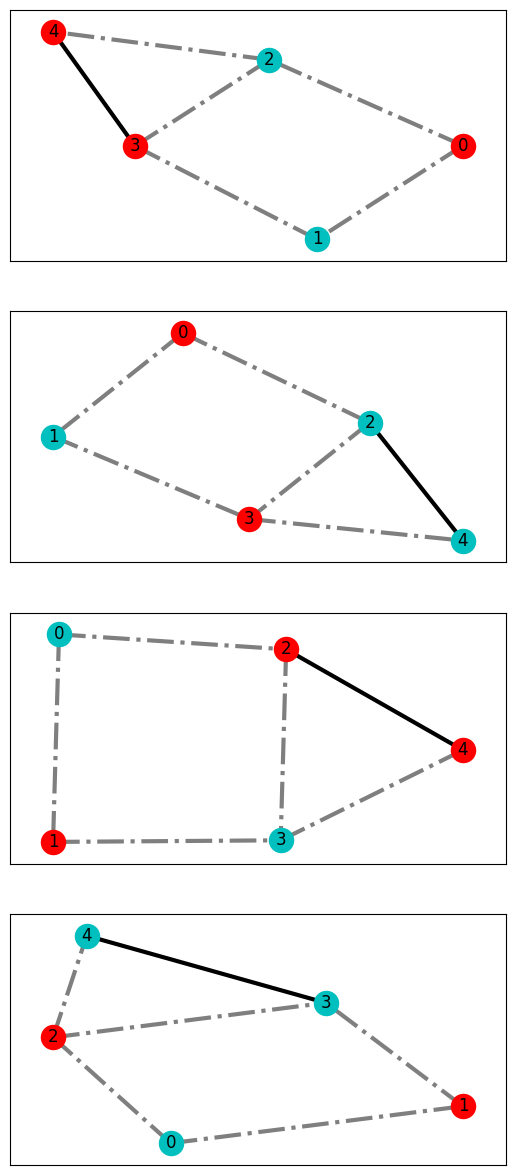

In [19]:
from matplotlib import pyplot as plt

def draw_result(G, ass, ax):
    S0 = [node for node in G.nodes if not ass[node]]
    S1 = [node for node in G.nodes if ass[node]]
    cut_edges = [(u, v) for u, v in G.edges if ass[u]!=ass[v]]
    uncut_edges = [(u, v) for u, v in G.edges if ass[u]==ass[v]]

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=S0, node_color='r')
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=S1, node_color='c')
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=uncut_edges, style='solid', width=3)
    nx.draw_networkx_labels(G, pos, ax=ax)

fig, axes = plt.subplots(len(min_sols))
fig.set_figheight(15)

i = 0
for sol in min_sols:
    draw_result(G, sol, axes[i])
    i += 1

In [20]:
from dimod import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()

response = sampler.sample_qubo(Q)

In [21]:
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

         [1, 2]      [0, 3, 4]     -5.0             5       
      [1, 2, 4]         [0, 3]     -5.0             5       
      [0, 3, 4]         [1, 2]     -5.0             5       
      [1, 2, 4]         [0, 3]     -5.0             5       
      [0, 3, 4]         [1, 2]     -5.0             5       
         [1, 2]      [0, 3, 4]     -5.0             5       
      [0, 3, 4]         [1, 2]     -5.0             5       
         [1, 2]      [0, 3, 4]     -5.0             5       
      [1, 2, 4]         [0, 3]     -5.0             5       
      [1, 2, 4]         [0, 3]     -5.0             5       


{0: 1, 1: 0, 2: 0, 3: 1, 4: 1}


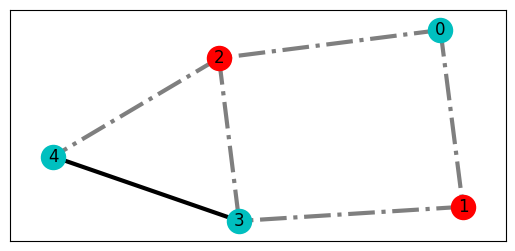

In [25]:
print(response.first.sample)

fig, axes = plt.subplots(1)
fig.set_figheight(3)
draw_result(G, response.first.sample, axes)

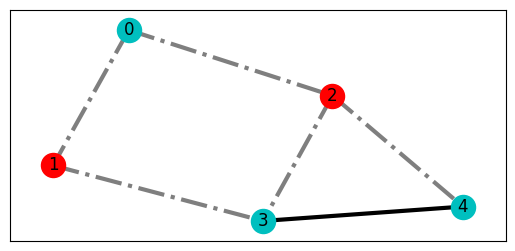

In [53]:
from collections import defaultdict
h = defaultdict(int)
J = defaultdict(int)

# Update J matrix for every edge in the graph
for i, j in G.edges:
    J[(i,j)]+= 1

r = sampler.sample_ising(h, J)
fig, axes = plt.subplots(1)
fig.set_figheight(3)

def draw_result(G, ass, ax):
    S0 = [node for node in G.nodes if ass[node] == -1]
    S1 = [node for node in G.nodes if ass[node] == 1]
    cut_edges = [(u, v) for u, v in G.edges if ass[u]!=ass[v]]
    uncut_edges = [(u, v) for u, v in G.edges if ass[u]==ass[v]]
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=S0, node_color='red')
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=S1, node_color='c')
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=uncut_edges, style='solid', width=3)
    nx.draw_networkx_labels(G, pos, ax=ax)

draw_result(G, r.first.sample, axes)


In [33]:
def score_cut_binary_ising(cut):
    score = 0

    for i, j in cut.graph.edges:
        x_i = -1 if i in cut.s0 else 1
        x_j = -1 if j in cut.s0 else 1
        s = x_i + x_j
        score += s

    return score

In [34]:
score_cut_binary_ising(cut)

-6

In [40]:
def ising_score(h, J, x):
    score = 0

    for i in range(0, Q.shape[1]):
        score += h[i]*x[i]

    for i in range(0, Q.shape[1]):
        for j in range(i+1, Q.shape[1]):
            score += J[i,j]*x[i]*x[j]
    return score
    
def score_cut_matrix_ising(cut):
    h = np.zeros(5)

    j = np.zeros((5, 5))

    for i, j in cut.graph.edges:
        J[i,j] += 1


    x = dict()
    for node in cut.graph.nodes:
        x[node] = -1 if node in cut.s0 else 1


    return ising_score(h, J, x)

In [41]:
score_cut_matrix_ising(cut)

0.0